## See detailed notes in [vishnu.uk/blogs/algorithms](http://vishnu.uk/blogs/algorithms.html#cycles-in-undirected-graphs)

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
def draw_graph(graph):
    G = nx.Graph(graph)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(4,2))
    nx.draw(G,pos, with_labels=True)

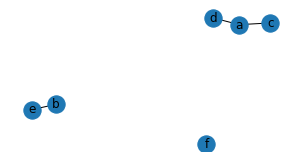

In [3]:
non_cyclic_graph = {'a': {'c', 'd'}, 'b': {'e'}, 'c': {'a'}, 'd': {'a'}, 'e': {'b'}, 'f': {}}
draw_graph(non_cyclic_graph)

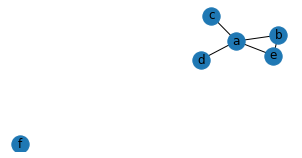

In [4]:
cyclic_graph = {'a': {'c', 'd', 'e', 'b'}, 'b': {'e', 'a'}, 'c': {'a'}, 'd': {'a'}, 'e': {'b', 'a'}, 'f': {}}
draw_graph(cyclic_graph)

### Check if cycles exist in an undirected graph using `Disjoint Union Sets`

In [5]:
from collections.abc import Iterable
from dataclasses import dataclass
from dataclasses import field
from typing import Generator
from typing import Hashable

@dataclass
class DSU:
    """Disjoint union set implementation."""

    parent: dict[Hashable, Hashable] = field(default_factory=dict)
    rank: dict[Hashable, int] = field(default_factory=dict)

    def add_nodes(self, ns: Iterable[Hashable]) -> 'DSU':
        for n in ns:
            self.add_node(n=n)
        return self

    def add_node(self, n: Hashable) -> 'DSU':
        self.parent[n] = n
        self.rank[n] = 1
        return self

    def find_leader(self, n: Hashable) -> Hashable:
        if self.parent[n] == n:
            return n
        self.parent[n] = self.find_leader(n=self.parent[n])
        return self.parent[n]

    def union(self, n1: Hashable, n2: Hashable) -> 'DSU':
        n1_leader = self.find_leader(n=n1)
        n2_leader = self.find_leader(n=n2)
        if n1_leader == n2_leader:
            return
        if self.rank[n1_leader] > self.rank[n2_leader]:
            self.parent[n2_leader] = n1_leader
        elif self.rank[n1_leader] < self.rank[n2_leader]:
            self.parent[n1_leader] = n2_leader
        else:
            # equal ht trees
            self.parent[n2_leader] = n1_leader
            self.rank[n1_leader] += 1
        return self

    def is_connected(self, n1: Hashable, n2: Hashable) -> bool:
        return self.find_leader(n=n1) == self.find_leader(n=n2)

def has_undirected_cycle_dsu(graph: dict[str, set[str]]) -> bool:
    """Finds cycles in an undirected graph.

    :param graph: The keys of the dict are the graph nodes which are strings. The set
        of strings they hold are the set of nodes connected to them.
    """
    dsu = DSU()
    dsu.add_nodes(ns=graph.keys())
    for n1, n2 in _iter_edges(graph):
        if dsu.is_connected(n1, n2):
            return True
        dsu.union(n1, n2)
    else:
        return False
    
def _iter_edges(graph: dict[str, set[str]]) -> Generator[tuple, None, None]:
    """Iterate through edges in a undirected graph. In an undirected graph, two
    connected nodes A and B will have each other in their edge set and hence the edge
    appears twice, we have to ensure we only yield an edge once.
    """
    seen = set()
    for n, adjs in graph.items():
        for adj in adjs:
            edge = tuple(sorted([n, adj]))
            if edge in seen:
                continue
            seen.add(edge)
            yield edge

In [6]:
dsu = DSU()
dsu.add_nodes(['a', 'b', 'c', 'd', 'e'])
dsu.union('a', 'd').union('b', 'e').union('c', 'd')
print(f"{dsu.is_connected('a', 'c')=}, {dsu.is_connected('b', 'e')=}, {dsu.is_connected('b', 'a')=}")

dsu.is_connected('a', 'c')=True, dsu.is_connected('b', 'e')=True, dsu.is_connected('b', 'a')=False


In [7]:
print(f"{has_undirected_cycle_dsu(non_cyclic_graph)=}")
print(f"{has_undirected_cycle_dsu(cyclic_graph)=}")

has_undirected_cycle_dsu(non_cyclic_graph)=False
has_undirected_cycle_dsu(cyclic_graph)=True


### Check if cycles exist in an undirected graph using `DFS`

In [8]:
from typing import Optional

def has_undirected_cycle_dfs(graph: dict[str, set[str]]) -> bool:
    seen = set()
    # The graph may not be fully connected, we need to DFS through each connected set.
    for n in graph:
        if n in seen:
            continue
        if _ucycle_dfs(graph=graph, node=n, parent=None, seen=seen):
            return True
    else:
        return False

def _ucycle_dfs(
        graph: dict[str, set[str]], node: str, parent: Optional[str], seen: set) -> bool:
    seen.add(node)
    for adj in graph[node]:
        if adj == parent:
            continue
        elif adj in seen:
            # We have reached neighbour before through different path, this is a cycle.
            return True
        elif _ucycle_dfs(graph=graph, node=adj, parent=node, seen=seen):
            return True
    else:
        return False

In [9]:
print(f"{has_undirected_cycle_dfs(non_cyclic_graph)=}")
print(f"{has_undirected_cycle_dfs(cyclic_graph)=}")

has_undirected_cycle_dfs(non_cyclic_graph)=False
has_undirected_cycle_dfs(cyclic_graph)=True
